In [80]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['SalesRegionID_x','SalesRegionID_y', 'HcoType', 'District', 'Status', ]
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity']
boolean_cols = ['IsReturn', 'IsMrsOrder']
data['Date'] = pd.to_datetime(data['Date'])

# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')
    
# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)
    
# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)
    
raw_data = data.copy()

In [81]:
# find MainDistID, DistID, HcoID, SalesRegionID_x, SalesRegionID_y number of unique values and create dataframe

unique_values = pd.DataFrame(raw_data.nunique(), columns=['Number of Unique Values'])
unique_values = unique_values.loc[['DistID', 'MainDistID', 'HcoID', 'SalesRegionID_x', 'SalesRegionID_y', 'District']]

unique_values

,Number of Unique Values
DistID,63
MainDistID,20
HcoID,5974
SalesRegionID_x,120
SalesRegionID_y,120
District,82


## Top 5 DistID with the highest TotalQuantity

In [82]:
dist_total_quantity = raw_data.groupby('DistID').agg({'TotalQuantity': 'sum'}).sort_values(by='TotalQuantity', ascending=False).head(5)
dist_total_quantity

,TotalQuantity
DistID,
2878817,5316099
2878856,2181228
2878809,1756165
2878859,1592056
2878812,1290500


## Top 5 DistID with the highest TotalQuantity for seceleced SKU's

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [83]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = ["319"]

data = data[data['SkuID'].isin(all_sku_ids)]

dist_total_quantity = data.groupby('DistID').agg({'TotalQuantity': 'sum'}).sort_values(by='TotalQuantity', ascending=False).head(5)
dist_total_quantity

,TotalQuantity
DistID,
2878817,162651
2878856,63156
2878809,50628
2878845,47795
2878859,47176


In [84]:
highest_dist_ids = ['2878817', '2878856', '2878809', '2878845', '2878859']
highest_dist_data = data[data['DistID'].isin(highest_dist_ids)]

highest_dist_data

,MainDistID,DistID,Date,HcoID,SalesRegionID_x,BrandID,SkuID,IsReturn,PaidQty,FGQty,IsMrsOrder,HcoType,District,SalesRegionID_y,Status,TotalQuantity
568,2879266,2878856,2019-12-29,2860455,340502,15,319,False,1,0,False,P,BAKIRKÖY,340502,Active,1
923,2879266,2878856,2020-12-04,2860455,340502,15,319,False,1,0,False,P,BAKIRKÖY,340502,Active,1
3693,2879266,2878856,2020-05-27,2862317,340302,15,319,False,2,0,False,P,BAĞCILAR,340302,Active,2
3745,2879266,2878856,2020-07-27,2862317,340302,15,319,False,2,0,False,P,BAĞCILAR,340302,Active,2
3891,2879266,2878856,2020-11-24,2862317,340302,15,319,False,3,0,False,P,BAĞCILAR,340302,Active,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200324,2879266,2878859,2021-12-03,2924903,1000000,15,319,False,2,0,False,P,Sultangazi,1000000,Active,2
4200333,2879266,2878859,2021-12-29,2924903,1000000,15,319,False,3,0,False,P,Sultangazi,1000000,Active,3
4200372,2879266,2878859,2021-12-04,2924983,1000000,15,319,False,3,0,False,P,Sultangazi,1000000,Active,3
4200455,2879266,2878859,2021-12-28,2925223,1000000,15,319,False,5,0,False,P,Sultangazi,1000000,Active,5


# Quarterly & Monthly Sales Analysis and Forecasting for MainDistID & DistID

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 4 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [85]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = ["319"]

data = data[data['SkuID'].isin(all_sku_ids)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206690 entries, 7 to 4201048
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   MainDistID       206690 non-null  object        
 1   DistID           206690 non-null  object        
 2   Date             206690 non-null  datetime64[ns]
 3   HcoID            206690 non-null  object        
 4   SalesRegionID_x  206690 non-null  category      
 5   BrandID          206690 non-null  int64         
 6   SkuID            206690 non-null  object        
 7   IsReturn         206690 non-null  bool          
 8   PaidQty          206690 non-null  int64         
 9   FGQty            206690 non-null  int64         
 10  IsMrsOrder       206690 non-null  bool          
 11  HcoType          206690 non-null  category      
 12  District         205359 non-null  category      
 13  SalesRegionID_y  206690 non-null  category      
 14  Status           206690 

# MainDistID Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly and monthly.


++++++++

## Quarterly Sales Analysis

Calculate the total sales of the choosen SKU and MainDistID for quarterly. It should be 12 rows in total for every SKU and MainDistID.

In [86]:
main_dist_data_quarterly = data.copy()
main_dist_data_quarterly['Year'] = main_dist_data_quarterly['Date'].dt.year
main_dist_data_quarterly['Quarter'] = main_dist_data_quarterly['Date'].dt.quarter

main_dist_data_quarterly = main_dist_data_quarterly.groupby(['Year', 'Quarter', 'MainDistID', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
main_dist_data_quarterly

,Year,Quarter,MainDistID,SkuID,TotalQuantity
0,2019,1,2879231,319,763
1,2019,1,2879236,319,554
2,2019,1,2879243,319,149
3,2019,1,2879244,319,8
4,2019,1,2879249,319,11532
...,...,...,...,...,...
129,2021,4,2879266,319,31130
130,2021,4,2879276,319,984
131,2021,4,2886479,319,461
132,2021,4,2915715,319,7853


In [87]:
def plot_sku_main_dist(sku_id):
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    sku_data['YearQuarter'] = sku_data['Year'].astype(str) + '-Q' + sku_data['Quarter'].astype(str)
    pivot_table = sku_data.pivot(index='YearQuarter', columns='MainDistID', values='TotalQuantity')
    pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title(f'Sales of SKU {sku_id} by MainDistID over Time')
    plt.xlabel('Year-Quarter')
    plt.ylabel('Total Quantity Sold')
    plt.legend(title='MainDistID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

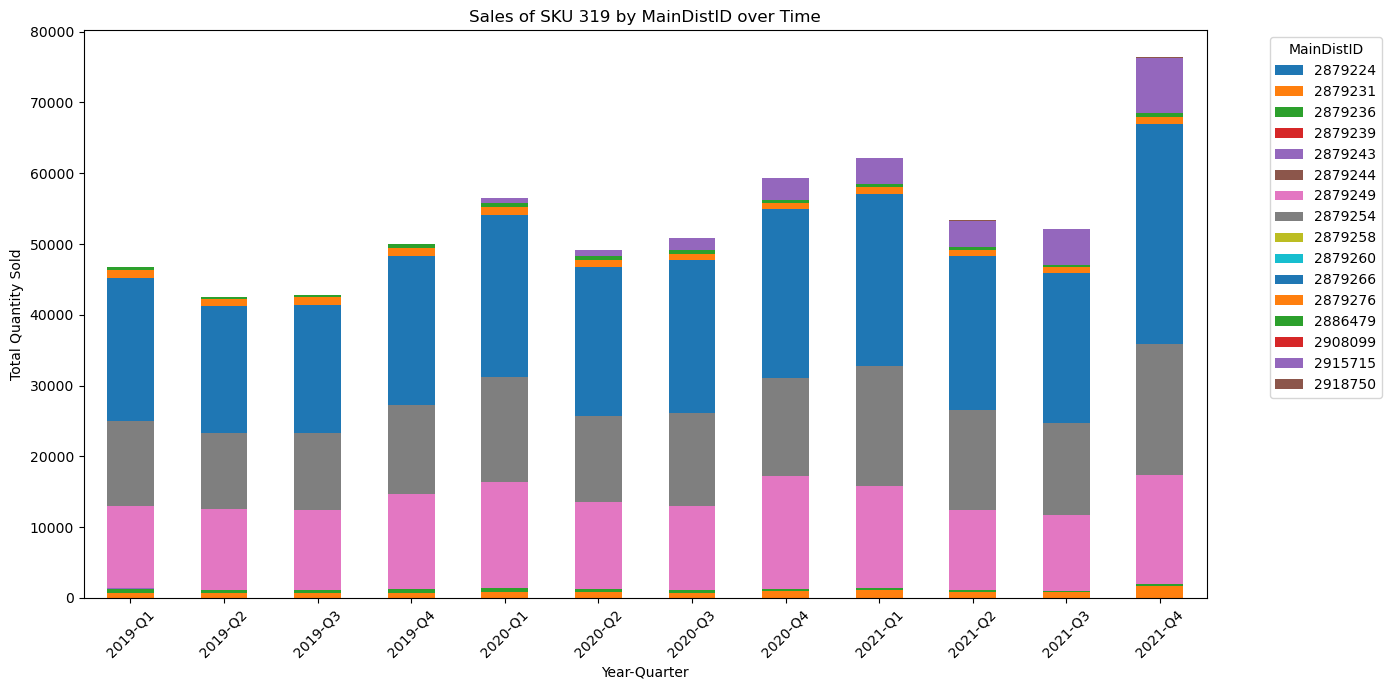

In [88]:
for sku_id in all_sku_ids:
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Quarter'], inplace=True)
    plot_sku_main_dist(sku_id)

In [89]:
sku_319 = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == "319"]
sku_319

,Year,Quarter,MainDistID,SkuID,TotalQuantity
0,2019,1,2879231,319,763
1,2019,1,2879236,319,554
2,2019,1,2879243,319,149
3,2019,1,2879244,319,8
4,2019,1,2879249,319,11532
...,...,...,...,...,...
129,2021,4,2879266,319,31130
130,2021,4,2879276,319,984
131,2021,4,2886479,319,461
132,2021,4,2915715,319,7853


### Is there any Trend, Seasonality, Randomness, Slighlty Increasing Trend, or Decreasing Trend in the data?

SKU 319


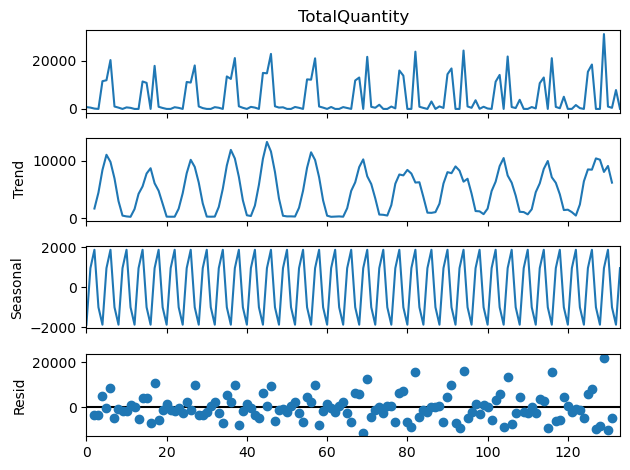

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=4)
    result.plot()
    plt.show()

In [103]:
## MUHTEMELEN EKSIK VAR BU KISIMDA

# Forecasting

Make forecasts for the choosen SKU's and every MainDistID using the following methods:
- Exponential Smoothing
- Moving Average
- Naive
- Triple Exponential Smoothing

### Evaluation Metrics
- Mean Absolute Percentage Error (MAPE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Bias

## Training and Testing Data
- Training Data: 2019-Q1 to 2020-Q4
- Testing Data: 2021-Q1 to 2021-Q4

```python
train = sku_data['TotalQuantity'][:-4]
test = sku_data['TotalQuantity'][-4:]
```

## Exponential Smoothing

In [178]:
def calculate_metrics(actual, forecasted):
    mape = (abs(forecasted - actual) / actual).mean()
    mse = ((forecasted - actual) ** 2).mean()
    rmse = mse ** 0.5
    bias = (forecasted - actual).mean()
    
    return mape, mse, rmse, bias

In [206]:
def NaiveForecast(train_data, forecast_periods=4):
    forecast = train_data.iloc[-1]
    forecast = forecast.astype(int)
    return forecast

def MovingAverageForecast(train_data, forecast_periods=4):
    forecast = train_data.rolling(window=2).mean().iloc[-forecast_periods:]
    return forecast

def ExponentialSmoothingForecast(train_data, forecast_periods=4):
    exp_smoothing = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = exp_smoothing.forecast(forecast_periods)
    forecast = forecast.astype(int)
    return forecast

def TripleExponentialSmoothingForecast(train_data, forecast_periods=4):
    triple_exp_smoothing = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = triple_exp_smoothing.forecast(forecast_periods)
    forecast = forecast.astype(int)
    return forecast


In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def plot_forecasts_and_calculate_metrics(sku_id, forecast_periods=4):
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Quarter'], inplace=True)
    
    main_dist_ids = sku_data['MainDistID'].unique()
    metrics_list = []

    for main_dist_id in main_dist_ids:
        dist_data = sku_data[sku_data['MainDistID'] == main_dist_id]['TotalQuantity']

        print(dist_data)
        
        if len(dist_data) == 0:
            print(f"No data available for MainDistID {main_dist_id}. Skipping.")
            continue
            
        train = dist_data[:-forecast_periods]
        test = dist_data[-forecast_periods:]
        
        # Check if the test data is empty
        if len(test) == 0:
            print(f"Not enough data for forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
        
        # Forecasting methods
        # 1. Naive
        naive_forecast = NaiveForecast(train, forecast_periods)
        mape, mse, rmse, bias = calculate_metrics(test, naive_forecast)
        metrics_list.append({'MainDistID': main_dist_id, 'Method': 'Naive', 'MAPE': mape, 'MSE': mse, 'RMSE': rmse, 'Bias': bias})
        
        # 2. Moving Average
        moving_avg_forecast = MovingAverageForecast(train, forecast_periods)
        mape, mse, rmse, bias = calculate_metrics(test, moving_avg_forecast)
        metrics_list.append({'MainDistID': main_dist_id, 'Method': 'Moving Average', 'MAPE': mape, 'MSE': mse, 'RMSE': rmse, 'Bias': bias})
        
        # 3. Exponential Smoothing
        exp_smoothing_forecast = ExponentialSmoothingForecast(train, forecast_periods)
        mape, mse, rmse, bias = calculate_metrics(test, exp_smoothing_forecast)
        metrics_list.append({'MainDistID': main_dist_id, 'Method': 'Exponential Smoothing', 'MAPE': mape, 'MSE': mse, 'RMSE': rmse, 'Bias': bias})
        
        # 4. Triple Exponential Smoothing
        triple_exp_smoothing_forecast = TripleExponentialSmoothingForecast(train, forecast_periods)
        mape, mse, rmse, bias = calculate_metrics(test, triple_exp_smoothing_forecast)
        metrics_list.append({'MainDistID': main_dist_id, 'Method': 'Triple Exponential Smoothing', 'MAPE': mape, 'MSE': mse, 'RMSE': rmse, 'Bias': bias})
        
        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Original (Train)')
        plt.plot(test.index, test, label='Original (Test)', color='gray')
        plt.plot(test.index, naive_forecast, label='Naive Forecast', linestyle='--')
        plt.plot(test.index, moving_avg_forecast, label='Moving Average Forecast', linestyle='--')
        plt.plot(test.index, exp_smoothing_forecast, label='Exponential Smoothing Forecast', linestyle='--')
        plt.plot(test.index, triple_exp_smoothing_forecast, label='Triple Exponential Smoothing Forecast', linestyle='--')
        
        plt.title(f'Sales Forecast for SKU {sku_id} - MainDistID {main_dist_id}')
        plt.xlabel('Year-Quarter')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    metrics_df = pd.DataFrame(metrics_list)
    print(metrics_df)
    return metrics_df

# Example usage:
metrics_df = plot_forecasts_and_calculate_metrics('319')


Year  Quarter
2019  1           763
      2           643
      3           711
      4           739
2020  1           858
      2           811
      3           764
      4           991
2021  1          1057
      2           907
      3           788
      4          1613
Name: TotalQuantity, dtype: int64


ValueError: cannot join with no overlapping index names